<a href="https://colab.research.google.com/github/gusmendesbh/project4-group2/blob/main/car_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

In [7]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2,274 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,053 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,731 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 P

In [8]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [10]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
sales_url = "https://car-sales-data-group2.s3.amazonaws.com/car_sales_data.csv"
spark.sparkContext.addFile(sales_url)
car_sales_df = spark.read.csv(SparkFiles.get("car_sales_data.csv"), sep=",", header=True)

# Show the sales data.
car_sales_df.show()

+----------+------------------+-----------------+---------+---------+--------+----------+--------------------+-----------------+
|      Date|       Salesperson|    Customer Name| Car Make|Car Model|Car Year|Sale Price|     Commission Rate|Commission Earned|
+----------+------------------+-----------------+---------+---------+--------+----------+--------------------+-----------------+
|2022-08-01|   Monica Moore MD|      Mary Butler|   Nissan|   Altima|    2018|     15983| 0.07049522770435404|          1126.73|
|2023-03-15|      Roberto Rose|   Richard Pierce|   Nissan|    F-150|    2016|     38474| 0.13443883688865882|           5172.4|
|2023-04-29|      Ashley Ramos|     Sandra Moore|     Ford|    Civic|    2016|     33340| 0.11453592158660743|          3818.63|
|2022-09-04|    Patrick Harris|     Johnny Scott|     Ford|   Altima|    2013|     41937| 0.09219072181202051|           3866.2|
|2022-06-16|        Eric Lopez|    Vanessa Jones|    Honda|Silverado|    2022|     20256| 0.11348

In [12]:
car_sales_df = car_sales_df.toPandas()

               Date      Salesperson    Customer Name   Car Make  Car Model  \
0        2022-08-01  Monica Moore MD      Mary Butler     Nissan     Altima   
1        2023-03-15     Roberto Rose   Richard Pierce     Nissan      F-150   
2        2023-04-29     Ashley Ramos     Sandra Moore       Ford      Civic   
3        2022-09-04   Patrick Harris     Johnny Scott       Ford     Altima   
4        2022-06-16       Eric Lopez    Vanessa Jones      Honda  Silverado   
...             ...              ...              ...        ...        ...   
2499995  2022-05-26   Isabella Moore      Shirley Lee  Chevrolet  Silverado   
2499996  2022-10-03    Kimberly Snow     Tara Rodgers       Ford      F-150   
2499997  2022-06-07    Jessica Young   Jennifer Moore  Chevrolet      Civic   
2499998  2023-02-15    Donald Barber      Ashley Diaz      Honda  Silverado   
2499999  2023-03-24     Kayla Fowler  Nathan Thompson      Honda      Civic   

        Car Year Sale Price      Commission Rate Co

In [13]:
car_sales_df.isnull().sum()

Date                 0
Salesperson          0
Customer Name        0
Car Make             0
Car Model            0
Car Year             0
Sale Price           0
Commission Rate      0
Commission Earned    0
dtype: int64

In [14]:
car_sales_df.describe()

,Date,Salesperson,Customer Name,Car Make,Car Model,Car Year,Sale Price,Commission Rate,Commission Earned
count,2500000,2500000,2500000,2500000,2500000,2500000,2500000,2500000,2500000
unique,366,518657,518251,5,5,13,40001,2500000,586911
top,2022-12-24,Michael Smith,Michael Smith,Honda,Silverado,2013,14817,0.07049522770435404,2218.59
freq,7144,1229,1167,500687,500842,192970,101,1,22


In [15]:
car_sales_df['Car Make'].value_counts()

Honda        500687
Chevrolet    500455
Toyota       500147
Ford         499781
Nissan       498930
Name: Car Make, dtype: int64

In [16]:
car_sales_df.Salesperson.value_counts()

Michael Smith         1229
Michael Johnson        976
David Smith            821
James Smith            796
Jennifer Smith         753
                      ... 
Mr. John Prince          1
Joseph Roberts MD        1
Matthew Bright DVM       1
Mario Cohen              1
Mr. Calvin Hardin        1
Name: Salesperson, Length: 518657, dtype: int64

In [17]:
car_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Date               object
 1   Salesperson        object
 2   Customer Name      object
 3   Car Make           object
 4   Car Model          object
 5   Car Year           object
 6   Sale Price         object
 7   Commission Rate    object
 8   Commission Earned  object
dtypes: object(9)
memory usage: 171.7+ MB


In [18]:
import datetime
car_sales_df['Date'] = pd.to_datetime(car_sales_df['Date'])
car_sales_df['Sale Price'] = car_sales_df['Sale Price'].astype(float)
car_sales_df['Commission Rate'] = car_sales_df['Commission Rate'].astype(float)
car_sales_df['Commission Earned'] = car_sales_df['Commission Earned'].astype(float)

In [19]:
car_sales_df = car_sales_df.sort_values(by=['Date']).reset_index(drop=True)


In [20]:
car_sales_df.head()

,Date,Salesperson,Customer Name,Car Make,Car Model,Car Year,Sale Price,Commission Rate,Commission Earned
0,2022-05-01,Sherri Collins,Laura Pena DDS,Nissan,F-150,2010,34903.0,0.092778,3238.24
1,2022-05-01,Antonio Brown,Rhonda Boyd,Toyota,Corolla,2019,25369.0,0.114699,2909.81
2,2022-05-01,Laura Delgado,Jennifer Garcia,Honda,Civic,2010,28079.0,0.123890,3478.70
3,2022-05-01,Jessica Banks,Brian Gonzalez,Toyota,Civic,2010,34979.0,0.087169,3049.07
4,2022-05-01,Thomas Bailey,Stephen Mitchell,Chevrolet,Corolla,2021,44299.0,0.062876,2785.32


In [21]:
counts = car_sales_df.Salesperson.value_counts()
top_5 = counts[5:].index
names_list = top_5.tolist()
salesperson_df = car_sales_df[car_sales_df['Salesperson'].isin(['Michael Smith','Michael Johnson','David Smith','James Smith', 'Jennifer Smith'])]
salesperson_df

,Date,Salesperson,Customer Name,Car Make,Car Model,Car Year,Sale Price,Commission Rate,Commission Earned
917,2022-05-01,David Smith,Stephanie Fields,Ford,F-150,2011,23247.0,0.102908,2392.30
1133,2022-05-01,David Smith,Leonard Chandler,Honda,Altima,2017,25946.0,0.133187,3455.66
1513,2022-05-01,Jennifer Smith,Catherine Barnett,Chevrolet,Altima,2016,23845.0,0.120236,2867.03
1734,2022-05-01,Michael Johnson,Brandon Lee,Chevrolet,Civic,2015,10029.0,0.128332,1287.05
1855,2022-05-01,James Smith,Edward Cochran,Chevrolet,Civic,2021,47159.0,0.057490,2711.18
...,...,...,...,...,...,...,...,...,...
2497507,2023-05-01,Michael Johnson,Angela Parker,Nissan,Corolla,2012,20309.0,0.100891,2049.00
2497759,2023-05-01,David Smith,Rhonda Moore,Nissan,F-150,2011,10403.0,0.080956,842.19
2497959,2023-05-01,James Smith,Eric Frederick,Chevrolet,Altima,2017,23964.0,0.079450,1903.94
2497986,2023-05-01,Jennifer Smith,Shirley Wright,Honda,Corolla,2021,44958.0,0.121929,5481.67


In [22]:
salesperson_df.Salesperson.value_counts()

Michael Smith      1229
Michael Johnson     976
David Smith         821
James Smith         796
Jennifer Smith      753
Name: Salesperson, dtype: int64

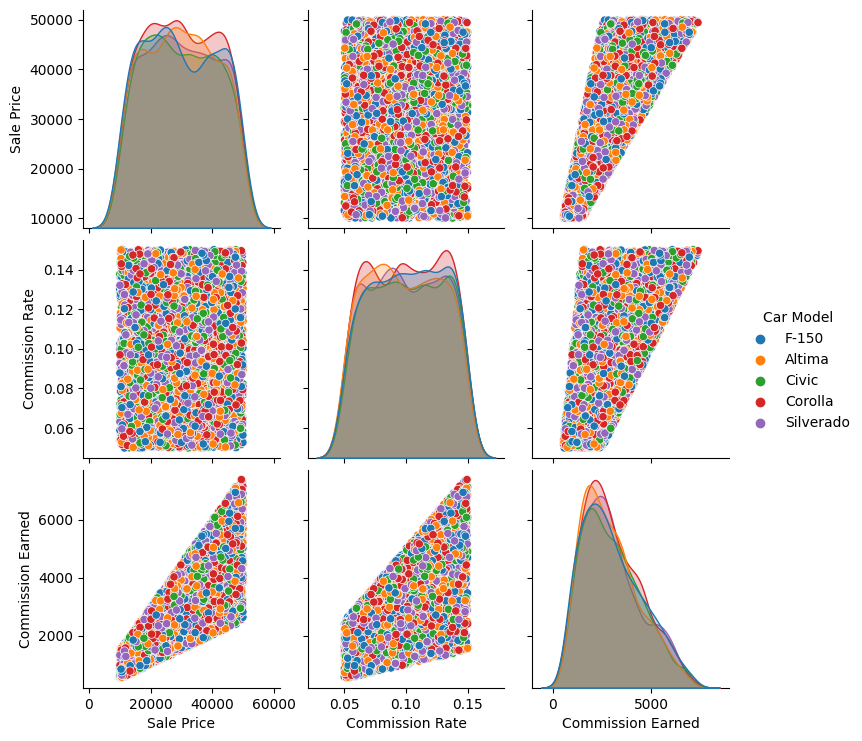

In [24]:
sb.pairplot(salesperson_df,hue="Car Model")

<ipython-input-26-4a088d23754a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(car_sales_df.corr(),linewidths=1,linecolor='white',annot=True)


<Axes: >

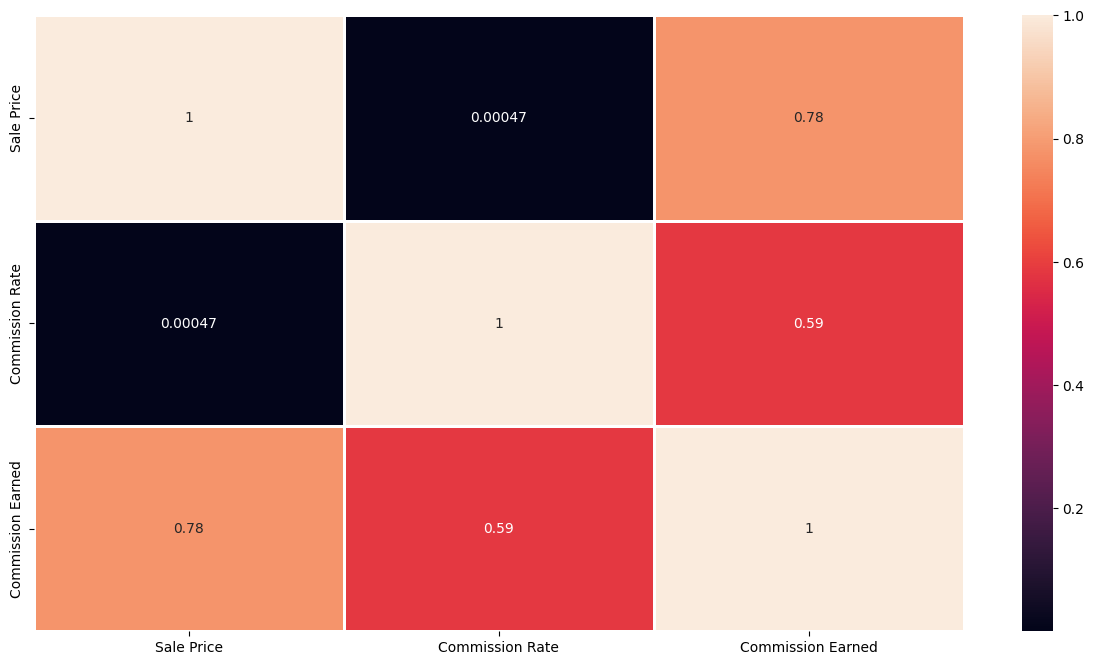

In [26]:
ax= plt.figure(figsize=(15,8))
sb.heatmap(car_sales_df.corr(),linewidths=1,linecolor='white',annot=True)

<Axes: xlabel='Car Make'>

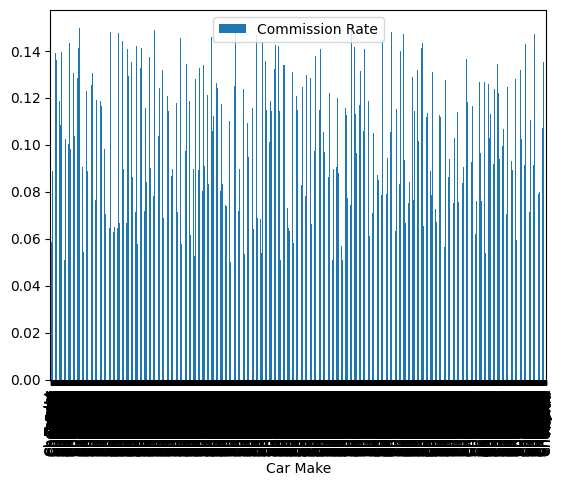

In [29]:
salesperson_df.plot(kind='bar', x="Car Make", y="Commission Rate")

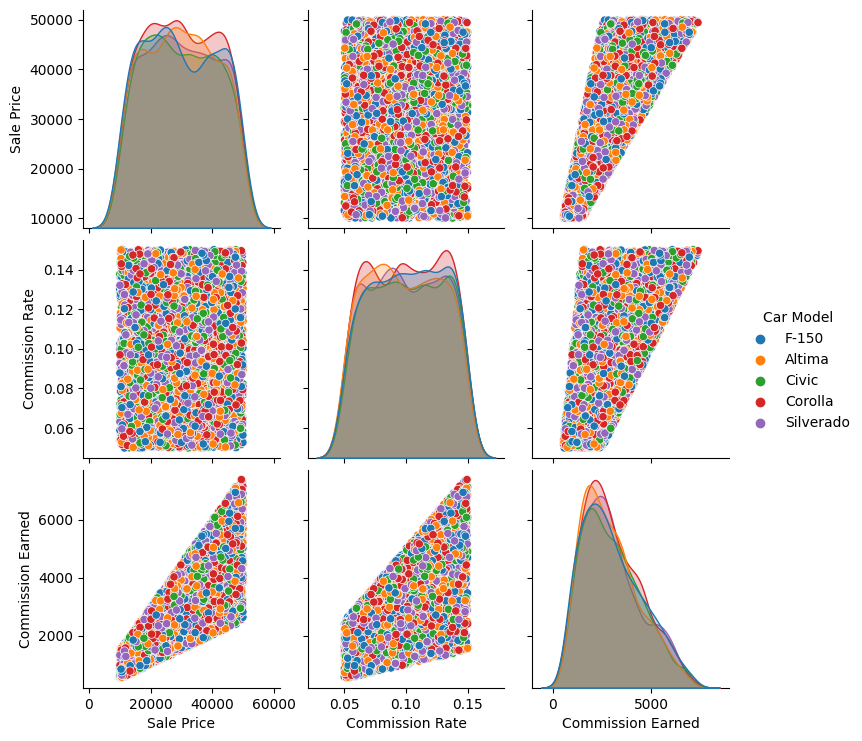

In [ ]:
sb.pairplot(salesperson_df,hue="Car Model")